# Coursework 2 – Machine Learning  
## Image Classification
**Student Name:** Bakhtiyor Sohibnazarov   
**Student ID:** Z22590018   
**Module:** CMP-X303-0 – Machine Learning   
**Updated:** 23th November 2025  

## Project Overview
The goal of this project is to develop a supervised learning model capable of accurately classifying images into multiple categories. The Intel Image Classification Dataset is used, which contains labeled images of various classes.  

The steps included in this notebook are:
1. Import required libraries.
2. Download and organize the dataset.
3. Prepare training, validation, and test datasets.
4. Design a CNN model.
5. Compile, train, and evaluate the model.
6. Visualize accuracy, loss, and confusion matrix.

## Importing Libraries
We will use the following libraries for this task:

- **TensorFlow/Keras**: Build and train the neural network.
- **NumPy**: Array manipulation and numerical operations.
- **Matplotlib**: Visualize accuracy, loss, and results.
- **kagglehub**: Download dataset from Kaggle.

If any library is missing, it can be installed using pip.

In [14]:
""" pip command to install above packages for our ML model to run.
Please note TensorFlow will take around 650MB of Storage space. 
Make sure you have sufficient storage before running this notebook
Remove -q argument to see the install progress
Please change Tensorflow edition according to your system. 
If on AMD use standard Tensorflow, intel is much more faster with intel-tensorflow """

!pip install intel-tensorflow numpy matplotlib kagglehub

In [8]:
# Import Required Libraries
import os
import shutil

# To download dataset if it does not exist
import kagglehub

# NumPy for numerical and array manipulation
import numpy as np

# Matplotlib for creating graphs
import matplotlib.pyplot as plt

# TensorFlow and Keras for building and training the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory


## Loading and Organising Dataset
We use the Intel Image Classification dataset. Kagglehub downloads the dataset to a default cache directory, so we move it to a working directory called `intel-data`.  

In [9]:
# Get currect working directory
current_dir = os.getcwd()

# Define target directory to copy dataset
target_dir = os.path.join(current_dir, "intel-data")

if os.path.exists(target_dir):
    print("Directory already exists. Please Continue below or delete intel-data directory to download data again")
    pass
else:
    
    # Download Intel Image Classification Dataset and capture its path in below variable
    path = kagglehub.dataset_download("puneet6060/intel-image-classification")
    print("Download Path: ", path)

    # Move from cache to target directory
    shutil.move(path, target_dir)
    print("Moved to: ", target_dir)

Directory already exists. Please Continue below or delete intel-data directory to download data again


## Prepare Training and Validation Sets
The `image_dataset_from_directory` utility automatically reads images from folders, assigns labels based on subfolder names, and prepares batches for training.  

- **Training set**: 80% of images used to train the model.
- **Validation set**: 20% of training images used to evaluate model performance during training.
- **Batch size**: 32 images per batch.
- **Image size**: 150x150 pixels, with 3 color channels (RGB).

In [10]:
# Assign corresponding directories to variables.
train_dir = os.path.join(target_dir, "seg_train/seg_train")

train = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

validation = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

num_classes = len(train.class_names)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


## Convolutional Neural Network (CNN) Architecture
The CNN consists of:

1. **Input Layer**: Accepts 150x150 RGB images.
2. **Conv2D + MaxPooling Layers**: Extract features from images.
3. **Flatten Layer**: Converts 2D feature maps into a 1D vector.
4. **Dense Layer**: Fully connected layer with 128 neurons.
5. **Dropout Layer**: 50% dropout to prevent overfitting.
6. **Output Layer**: Number of neurons = number of classes, with softmax activation for multi-class classification.

This model is suitable for extracting patterns from images and making predictions.

In [11]:
model = Sequential([
    Input(shape=(150,150,3)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    
    Dense(128, activation='relu'),
    
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,126 (40.58 MB)

 Trainable params: 10,637,126 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Model
- **Optimizer**: Adam optimizer for efficient gradient descent.
- **Loss function**: Categorical crossentropy for multi-class classification.
- **Metrics**: Accuracy to monitor model performance.

We train the model for 3 epochs with the training and validation datasets.

In [12]:
model.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)

history = model.fit(
train,
validation_data=validation,
epochs=3
)

Epoch 1/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 333s 940ms/step - accuracy: 0.3567 - loss: 14.3531 - val_accuracy: 0.4715 - val_loss: 1.3392
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 330s 939ms/step - accuracy: 0.5268 - loss: 1.2072 - val_accuracy: 0.5110 - val_loss: 1.2417
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 329s 939ms/step - accuracy: 0.6228 - loss: 0.9714 - val_accuracy: 0.5449 - val_loss: 1.1613


## Model Evaluation
We evaluate the model using:

1. **Accuracy and Loss Plots**: Shows training vs validation performance over epochs.
2. **Confusion Matrix**: Illustrates correct vs incorrect predictions for each class.

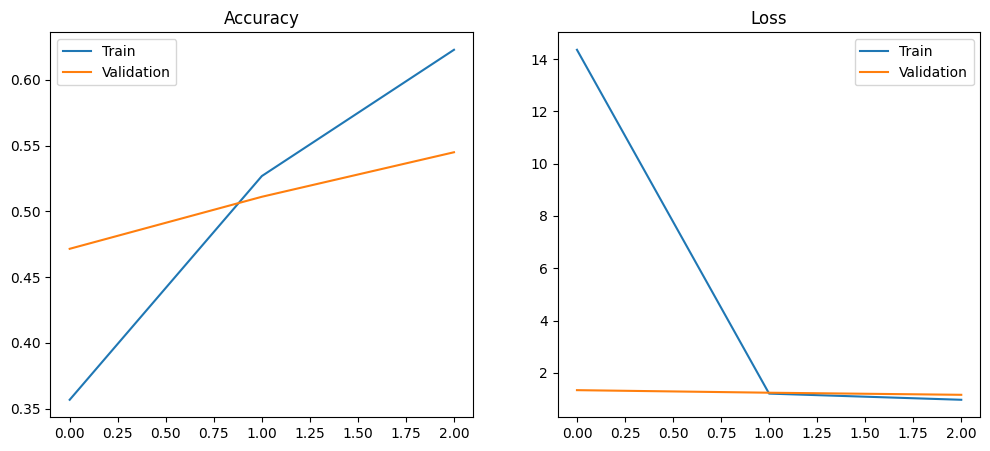

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()


In [16]:
y_true = np.concatenate([y for x, y in validation], axis=0)
y_pred = np.argmax(model.predict(validation), axis=1)
y_true_classes = np.argmax(y_true, axis=1)


conf_matrix = tf.math.confusion_matrix(y_true_classes, y_pred)
print('Confusion Matrix:\n', conf_matrix)


2025-11-24 22:29:50.277186: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step
Confusion Matrix:
 tf.Tensor(
[[ 77  62  97  73  50  80]
 [ 83  77 105  71  50  87]
 [ 73  77 106  78  41  88]
 [103  73 101  74  44 105]
 [ 66  76 111  73  43  87]
 [ 86  70  94  84  40 101]], shape=(6, 6), dtype=int32)


In [17]:
# Load test dataset
test_dir = os.path.join(target_dir, "seg_test/seg_test")
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Found 3000 files belonging to 6 classes.
Classes in test dataset: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.5313 - loss: 1.2040
Test Accuracy: 53.13%
